# import

In [1]:
from astropy.io import fits
import time
#import urllib2# python2
import urllib#python3

import datetime
#from itertools import ifilter python2
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
import h5py
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import bibtexparser
import astropy.coordinates as coord
from astropy import units as u
from astropy.coordinates import SkyCoord

pd.set_option('mode.chained_assignment','warn')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import cm

import os
from collections import OrderedDict
from adjustText import adjust_text

%matplotlib inline
%config InlineBackend.figure_format='svg'
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [3]:
from adjustText import adjust_text
import matplotlib as mpl
def set_ax_tick(ax):
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on',)
    ax.xaxis.set_tick_params(which='minor', size=5, width=2, direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=5, width=2, direction='in', right='on')

def set_ax_locator(ax,xma=1,xmi=0.2,yma=1,ymi=0.2):
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xma))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xmi))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yma))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(ymi)) 

In [4]:
import pandas as pd
import numpy as np
import os

def get_obsids(path):
    dirname=os.listdir(path)
    obsids=[]
    for i in dirname:
        if i.isdigit():
            obsids.append(i)
    obsids.sort()        
    return obsids

def drop_index(data):
    data=data.reset_index(drop=True)
    return data

In [5]:
from astropy.cosmology import FlatLambdaCDM,Planck13,Planck15,z_at_value
from astropy import units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.27, Ode0=0.73)
#cosmo=FlatLambdaCDM(H0=73,Om0=0.3)

In [6]:
from astropy.visualization import hist
from astroML.datasets import fetch_imaging_sample, fetch_sdss_S82standards
from astroML.crossmatch import crossmatch_angular
from collections import Counter

In [7]:
from astropy.table import Table

## linerfit

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting

In [8]:
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling import models,fitting
from astropy.modeling.models import custom_model
from scipy.optimize import least_squares,curve_fit
from scipy.stats import f
import os

def linear(x,k,b):#linear
    return k*x+b

def broken_linear_curve(x,k1,k2,x0,b1,b2):#two lines divided by x0
    return np.where(x<x0,k1*x+b1,k2*x+b2)    

def broken_linear_curve_dot(x,k1,k2,x0,y0):#connect by x0,y0
    return np.where(x<x0,k1*(x-x0)+y0,k2*(x-x0)+y0) 

def power_law(x,S0,alpha):
    return S0*x**alpha



def alpha_calc(x,y):
    popt,pcov=curve_fit(power_law,x,y,p0=(10,0.5))
    S0=popt[0]
    alpha=popt[1]
    alpha_err=np.sqrt(np.diag(pcov))[1]
    return S0,alpha,alpha_err

def linear_calc(x,y):#linear_parameter
    popt,pcov=curve_fit(linear,x,y,p0=(1,1))
    return popt[0],popt[1]

def broken_linear_curve_calc(x,y):
    param_bounds=([-np.inf,0,-4,-np.inf,-np.inf],[-0,np.inf,-2.5,np.inf,np.inf])
    popt,pcov=curve_fit(broken_linear_curve,x,y,p0=(-1.5,1.5,-2.7,2,-1.5),bounds=param_bounds)
    k1=popt[0]
    k2=popt[1]
    x0=popt[2]
    b1=popt[3]
    b2=popt[4]
    return k1,k2,x0,b1,b2

def broken_linear_curve_dot_calc(x,y):
    param_bounds=([-np.inf,0,-3.5,0],[0,np.inf,-2.5,2])
    popt,pcov=curve_fit(broken_linear_curve_dot,x,y,p0=(-1.5,1.5,-2.7,1),bounds=param_bounds)
    k1=popt[0]
    k2=popt[1]
    x0=popt[2]
    y0=popt[3]
    return k1,k2,x0,y0


def decay_e_timescale(t,tau,S0):
    logey=-t/tau+S0
    return logey
#logy=-(x-x[0])/tau+S0

def decay_e_timescale_calc(x,y,tau_test=1000,S0_test=1):
    logey=np.log(y)
    param_bounds=([0,-np.inf],[np.inf,np.inf])
    popt,pcov=curve_fit(decay_e_timescale,x,logey,p0=(tau_test,S0_test),bounds=param_bounds)
    tau=popt[0]
    S0=popt[1]    
    return tau,S0


def exp_timescale(t,Tr,Tf,tp,S0):
    logey=-(np.exp((tp-t)/Tr)+np.exp((t-tp)/Tf))+S0
    return logey


def exp_timescale_calc(x,y,Tr_test=10000,Tf_test=2000,tp_test=50000,S0_test=1):
    logey=np.log(y)
    param_bounds=([1,1,45700,-np.inf],[np.inf,np.inf,58300,np.inf])
    popt,pcov=curve_fit(exp_timescale,x,logey,p0=(Tr_test,Tf_test,tp_test,S0_test),bounds=param_bounds)
    Tr=popt[0]
    Tf=popt[1]
    tp=popt[2] 
    S0=popt[3]    
    return Tr,Tf,tp,S0


## def alpha_calc_2freq_2logflux

In [46]:
def alpha_calc_2freq_2logflux(freq1,freq2,logflux1,logflux2):    
    #Get lightcurve values
    
    alpha= (logflux1-logflux2)/(np.log10(freq2)-np.log10(freq1))
    
    return alpha

# Surveyfits_path


In [9]:
Surveyfits_path='/Volumes/ExtremeSSD/Survey_fits/Survey_fits/Survey_fits'

# 3CRR

In [10]:
sample_3Cdir='/Volumes/ExtremeSSD/Survey_fits/3CR/3Csample'

In [11]:
p3CRR=pd.read_csv('%s/3CRR_table_ascii.txt'%sample_3Cdir,header=0,delimiter='\s+')
p3CRR_NED=pd.read_csv('%s/3CRR_NED.py'%sample_3Cdir,header=None,delimiter='|')
p3CRR_NED.columns=['index','1','Name','*','Ned_name','ra','dec','class','z','z_qual','index0']

Coord_p3CRR_NED = SkyCoord(p3CRR_NED['ra'], p3CRR_NED['dec'], frame="icrs",) 

p3CRR_NED['ra_deg']=Coord_p3CRR_NED.ra.deg
p3CRR_NED['dec_deg']=Coord_p3CRR_NED.dec.deg

In [12]:
p3CRR_NEDX = np.empty((len(p3CRR_NED), 2), dtype=np.float64)
p3CRR_NEDX[:, 0] = p3CRR_NED['ra_deg']
p3CRR_NEDX[:, 1] = p3CRR_NED['dec_deg']

In [29]:
p3CRR.columns

Index(['3CRR_name', 'IAU_name', 'Redshift', '178-MHz_flux', 'Sp.index',
       'FR_class', '5-GHz_core_flux', '`Best'_radio_map'],
      dtype='object')

In [13]:
p3CRR_OIII=pd.read_excel('%s/3CRROIIIdata.xlsx'%sample_3Cdir,sheet_name='Sheet1')

In [ ]:
p3CRR_OIII

In [ ]:
p3CRR_OIII.columns

L_151 L_[OIII]
4C12.03
3C6.1
3C16
3C20
3C31
3C35
3C42
3C43
3C55
3C66B
3C76.1
3C83.1B
4C14.11
3C123
3C173.1
DA240
3C196
4C14.27
3C216
3C219
3C228
3C236
4C74.16
3C264
3C268.1
A1552
3C274
3C274.1
3C285
3C289
3C295
3C296
3C305
3C315
3C319
3C322
3C326
3C337
3C338
NGC6251
3C346
3C349
3C386
3C388
3C401
3C433
3C436
3C438
3C449
NGC7385
3C465
3C470
6C0822+3434
6C0824+3535
6C0905+3955
6C0913+3907
6C0930+3855
6C1016+3637
6C1113+3458
6C1148+3638
6C1213+3504
6C1217+3645
5C6.43
5C6.63
5C6.201
5C6.214
5C6.233
5C6.402
5C7.70
5C7.79
5C7.106
5C7.145
5C7.170
5C7.178
5C7.312a
5C7.312c


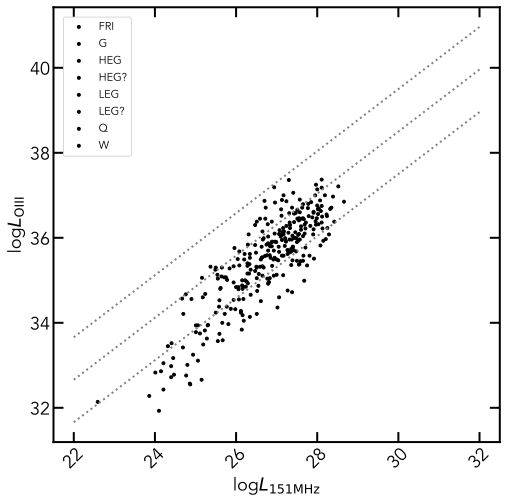

In [14]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)


#ax.hist(BAT_105m_Seyfert_data_1['sigma_m_w1_neo'],bins=50,lw=2,histtype='step',ec='red', fc='red',label='Type1',linestyle='-.')

#ax.axvline(np.mean(BAT_105m_Seyfert_data_1['sigma_m_w1_neo']),color='red',ls=':')

log_L200=np.linspace(22,32,10)
y_log_L200=0.73*log_L200+16.6
ax.plot(log_L200,y_log_L200,ls=':',color='grey',linewidth=2)
ax.plot(log_L200,y_log_L200-1,ls=':',color='grey',linewidth=2)
ax.plot(log_L200,y_log_L200+1,ls=':',color='grey',linewidth=2)
delta_yLOIII=1.0

#p3CR
plotdata=p3CRR_OIII
column_x=4
column_y=5
column_label=1

print(plotdata.columns[column_x],plotdata.columns[column_y])
for i in range(len(plotdata)):
    name_class=plotdata.loc[i,plotdata.columns[column_label]] 
    
    if isinstance(plotdata[plotdata.columns[column_x]][i],(int,float)) and isinstance(plotdata[plotdata.columns[column_y]][i],(int,float)):
        ax.scatter(plotdata[plotdata.columns[column_x]][i],
                   plotdata[plotdata.columns[column_y]][i],
                   color='black',marker='.',label=name_class.strip())
        
        if plotdata[plotdata.columns[column_x]][i]*0.73+16.6-plotdata[plotdata.columns[column_y]][i]>delta_yLOIII:
            print(plotdata['Name'][i])
'''            ax.text(
                    plotdata[plotdata.columns[column_x]][i],
                    plotdata[plotdata.columns[column_y]][i],
                    plotdata['Name'][i],
            
            )'''

#set_ax_locator(ax,xma=0.2,xmi=0.1,yma=10,ymi=5)
set_ax_tick(ax)

#ax.set_xlabel('Type')
#ax2.set_xlabel('Type')
ax.set_xlabel(r'log$ L_\mathrm{ 151MHz}$')
ax.set_ylabel(r'log$L_\mathrm{OIII}$')

ax.xaxis.set_tick_params(which='major', size=10, width=2, rotation=45,)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars

#hdl = [h[0] for h in handles]
hdl=handles
labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))

ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)

# use them in the legend
#by_label = OrderedDict(zip(labels, handles)) 
#ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.0, 0.9),loc=2, numpoints=1, fontsize=11. )


#ax.semilogy()
#ax.semilogx()

#ax.set_xlim(0.0,0.6)
#plt.legend()
fig.savefig('3CRR_cat_LOIII_Lradio.png', dpi=400, transparent=False, bbox_inches='tight')


## p3CRR_distance

In [47]:
p3CRR_distance=p3CRR[p3CRR['5-GHz_core_flux'].str.contains('<')==False]
p3CRR_distance=p3CRR_distance[p3CRR_distance['5-GHz_core_flux'].str.contains('--')==False]
p3CRR_distance=drop_index(p3CRR_distance)

In [48]:
len(p3CRR_distance),len(p3CRR)

(151, 173)

In [49]:
for i in range(len(p3CRR_distance)):
     p3CRR_distance.loc[i,'5GHz_flux_Jy']=float(p3CRR_distance.loc[i,'5-GHz_core_flux'])*1.0e-3
        
p3CRR_distance['D_cm']=cosmo.luminosity_distance(z=p3CRR_distance['Redshift']).to(u.cm).value
p3CRR_distance['L178MHz']=p3CRR_distance['178-MHz_flux']*4*np.pi*p3CRR_distance['D_cm']**2*1.0e-23
p3CRR_distance['logL178MHz']=np.log10(p3CRR_distance['L178MHz'])

p3CRR_distance['L5GHz']=p3CRR_distance['5GHz_flux_Jy']*4*np.pi*p3CRR_distance['D_cm']**2*1.0e-23
p3CRR_distance['logL5GHz']=np.log10(p3CRR_distance['L5GHz'])

        

In [52]:
p3CRR_distance.columns

Index(['3CRR_name', 'IAU_name', 'Redshift', '178-MHz_flux', 'Sp.index',
       'FR_class', '5-GHz_core_flux', '`Best'_radio_map', '5GHz_flux_Jy',
       'D_cm', 'L178MHz', 'logL178MHz', 'L5GHz', 'logL5GHz', 'alpha'],
      dtype='object')

In [51]:
for i in range(len(p3CRR_distance)):
    freq1=5e9
    freq2=178e6
    logflux1=p3CRR_distance.loc[i,'logL5GHz']
    logflux2=p3CRR_distance.loc[i,'logL178MHz']
    
    p3CRR_distance.loc[i,'alpha']=alpha_calc_2freq_2logflux(freq1,freq2,logflux1,logflux2)

In [36]:
p3CRR_distance.columns

Index(['3CRR_name', 'IAU_name', 'Redshift', '178-MHz_flux', 'Sp.index',
       'FR_class', '5-GHz_core_flux', '`Best'_radio_map', '5GHz_flux_Jy',
       'D_cm', 'L178MHz', 'logL178MHz', 'L5GHz', 'logL5GHz', 'alpha'],
      dtype='object')

## alpha_vs_spectral_index

Sp.index alpha


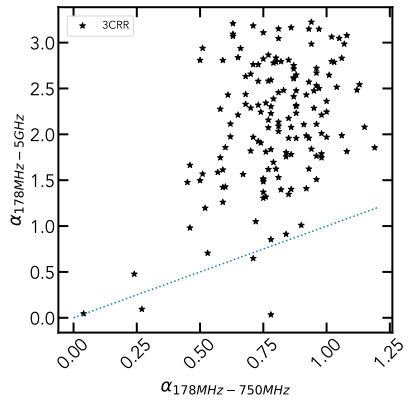

In [57]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

#ax.hist(BAT_105m_Seyfert_data_1['sigma_m_w1_neo'],bins=50,lw=2,histtype='step',ec='red', fc='red',label='Type1',linestyle='-.')

#ax.axvline(np.mean(BAT_105m_Seyfert_data_1['sigma_m_w1_neo']),color='red',ls=':')

#p3CR
plotdata=p3CRR_distance
column_x=4
column_y=14
print(plotdata.columns[column_x],plotdata.columns[column_y])
for i in range(len(plotdata)):
    if isinstance(plotdata[plotdata.columns[column_x]][i],float) and isinstance(plotdata[plotdata.columns[column_y]][i],float):
        ax.scatter(plotdata[plotdata.columns[column_x]][i],
                   plotdata[plotdata.columns[column_y]][i],
                   color='black',marker='*',label='3CRR')
        
set_ax_tick(ax)

ax.plot(np.linspace(0,1.2,10),np.linspace(0,1.2,10),ls=':')
#ax.set_xlabel('Type')
#ax2.set_xlabel('Type')
ax.set_ylabel(r'$\alpha_{178MHz-5GHz}$')
ax.set_xlabel(r'$\alpha_{178MHz-750MHz}$')


ax.xaxis.set_tick_params(which='major', size=10, width=2, rotation=45,)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
#hdl = [h[0] for h in handles]
hdl = handles
labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))

ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)        
        

In [55]:
np.mean(p3CRR_distance['Sp.index']),np.std(p3CRR_distance['Sp.index'])

(0.7976821192052977, 0.17875375681175742)

In [56]:
np.mean(p3CRR_distance['alpha']),np.std(p3CRR_distance['alpha'])

(2.135397887219527, 0.6793372891480793)

## clip

In [ ]:
p3CRR_OIII.columns

In [15]:
p3CRR_OIII['select']=0
for index, i in enumerate(p3CRR_OIII['L_[OIII]']):
    if isinstance(p3CRR_OIII['L_[OIII]'][index],(int,float)) and isinstance(p3CRR_OIII['L_151'][index],(int,float)):
        p3CRR_OIII.loc[index,'select']=1        
        

p3CRR_OIII_float=p3CRR_OIII.select_dtypes(include='number')

In [ ]:
p3CRR_OIII

In [16]:
p3CRR_OIII_float=p3CRR_OIII[p3CRR_OIII['select']==1]
#p3CRR_OIII_float=p3CRR_OIII_float[p3CRR_OIII_float['L_[OIII]'].str.contains('<')==False]
#p3CRR_OIII_float=p3CRR_OIII_float[p3CRR_OIII_float['L_151'].str.contains('<')==False]
#p3CRR_OIII_float=p3CRR_OIII_float[p3CRR_OIII_float['L_151'].str.contains('>')==False]
p3CRR_OIII_float=drop_index(p3CRR_OIII_float)

In [17]:
len(p3CRR_OIII_float),len(p3CRR_OIII)

(300, 301)

In [18]:
p3CRR_OIII_float['L_151'].dtype

dtype('float64')

p3CRR_OIII_float['L_[OIII]'].astype(float)

In [21]:
dataplot=p3CRR_OIII_float

x=np.array(dataplot['L_151']).astype(float)
y=np.array(dataplot['L_[OIII]']).astype(float)
#x= np.log10(dataplot['L200MHz']) #log
#y= np.log10(dataplot['oiii_5007_Lum'])#log
#xerr= dataplot['L200MHz_err']/np.log(10)/x
#yerr= dataplot['oiii_5007_Lum_err']/np.log(10)/y

weights=np.zeros(len(x))+1

#xerr

# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=2.0)

# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line, mask = or_fit(line_init, x, y, weights=1.0/weights)
filtered_data = np.ma.masked_array(y, mask=mask)

print(fitted_line)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    0.9251819090106739 10.734868897538977


In [22]:
fitted_line.slope.value,fitted_line.intercept.value

(0.9251819090106739, 10.734868897538977)

In [23]:
len(mask),len(x),np.sum(mask)

(300, 300, 63)

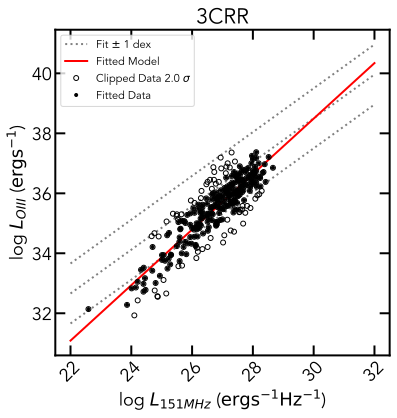

In [24]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

log_L200=np.linspace(22,32,10)
y_log_L200=0.73*log_L200+16.6


sigma=2.0

ax.plot(log_L200,y_log_L200,ls=':',color='grey',linewidth=2,label=r'Fit $\pm$ 1 dex')
ax.plot(log_L200,y_log_L200-1,ls=':',color='grey',linewidth=2)
ax.plot(log_L200,y_log_L200+1,ls=':',color='grey',linewidth=2)

ax.errorbar(x, y, 
            #xerr=xerr, yerr=yerr, 
            markersize=10,
            fmt="k.", fillstyle="none", label=r"Clipped Data %.1f $\sigma$"%sigma)

ax.errorbar(x, filtered_data, markersize=3,
            fmt="ko", label="Fitted Data")

#plt.plot(x, line_orig(x), 'b-', label='Simulation Model')
ax.plot(log_L200, fitted_line(log_L200), color='red',ls='-', linewidth=2,label='Fitted Model')
#plt.xlim(-2,12)
#plt.ylim(-5,25)

set_ax_tick(ax)
#set_ax_locator(ax)

#ax.set_xlabel(r'$L_{5GHz}$ ($\mathrm{erg s^{-1} Hz^{-1}}$)')
#ax.set_ylabel(r'$L_{178MHz}$ ($\mathrm{erg s^{-1} Hz^{-1} } $)')
ax.set_xlabel(r'log $L_{151MHz}$ ($\mathrm{erg s^{-1} Hz^{-1}}$)')
ax.set_ylabel(r'log $L_{OIII}$ ($\mathrm{erg s^{-1}}$)')


ax.xaxis.set_tick_params(which='major', size=10, width=2, rotation=45,)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
#hdl = [h[0] for h in handles]
hdl = handles
labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))

#ax.set_title('Plate = %(plate)i, MJD = %(mjd)i, Fiber = %(fiber)i' % locals())
ax.set_title('3CRR')

#ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),loc=2, numpoints=1,ncol=1,fontsize=11.)
plt.legend(fontsize=11.)
#plt.show()
fig.savefig('3CRR_cat_LOIII_Lradio_clip_%s_sigma.png'%sigma, dpi=400, transparent=False, bbox_inches='tight')
#plt.savefig('L200MHz_LOIII_TGSS_SDSS.png',dpi=400, transparent=False, bbox_inches='tight')


## select fading

3C6.1 Fading
2.436735761269211 0.68

3C20 Fading
2.9376082973652364 0.66

3C35 Fading
2.0736780944043733 0.77

3C43 Fading
3C55 Fading
2.515138738750196 1.04

3C123 Fading
2.287713379401241 0.7

3C173.1 Fading
2.316853099512159 0.88

DA240 Fading
1.618376088184953 0.77

3C196 Fading
2.7792556474491197 0.79

3C236 Fading
1.5682029361557517 0.51

4C74.16 Fading
2.71383017851708 0.87

3C268.1 Fading
2.807169873094857 0.59

3C274.1 Fading
2.6082297781204917 0.87

3C289 Fading
2.13452447348317 0.81

3C295 Fading
3.094073474391191 0.63

3C319 Fading
3C322 Fading
3.1509243202176274 0.81

3C337 Fading
3.208858310652404 0.63

NGC6251 Fading
1.0495943824852318 0.72

3C386 Fading
1.6136545221218292 0.59

3C388 Fading
1.819573436085763 0.7

3C401 Fading
1.9694072449610425 0.71

3C433 Fading
2.8224710672471782 0.75

3C438 Fading
2.6483522192033537 0.88

3C465 Fading
1.5073925296458335 0.75

3C470 Fading
2.5821426145179136 0.77

6C0824+3535 Fading
6C0930+3855 Fading
6C1113+3458 Fading
5C6.43 Fading


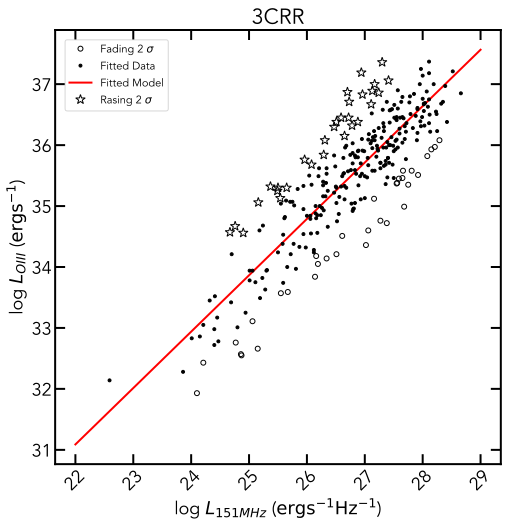

In [45]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

log_L200=np.linspace(22,29,10)
y_log_L200=0.73*log_L200+16.6

ax.errorbar(x, filtered_data, markersize=3,
            fmt="ko", label="Fitted Data")



for index, (name,x_,y_,mask_) in enumerate(zip(p3CRR_OIII_float['Name'].values,x,y,mask)):
    if mask_:
        if x_*fitted_line.slope.value+fitted_line.intercept.value>y_:
            print(name,'Fading')
            p3CRR_selectFading=p3CRR_distance[p3CRR_distance['3CRR_name']==name]
            
            
            if len(p3CRR_selectFading)>0:
                p3CRR_selectFading=drop_index(p3CRR_selectFading)
                print(p3CRR_selectFading.loc[0,'alpha'],p3CRR_selectFading.loc[0,'Sp.index'])
                print()
            
            ax.errorbar(x_, y_, 
            #xerr=xerr, yerr=yerr, 
            markersize=10,
            fmt="k.", fillstyle="none", label=r"Fading 2 $\sigma$")

        else:
            #print(name,'Rasing')
            ax.errorbar(x_, y_, 
            #xerr=xerr, yerr=yerr, 
            markersize=10,
            fmt="k*", fillstyle="none", label=r"Rasing 2 $\sigma$")            
            
#plt.plot(x, line_orig(x), 'b-', label='Simulation Model')
ax.plot(log_L200, fitted_line(log_L200), color='red',ls='-', linewidth=2,label='Fitted Model')
#plt.xlim(-2,12)
#plt.ylim(-5,25)

set_ax_tick(ax)
#set_ax_locator(ax)

#ax.set_xlabel(r'$L_{5GHz}$ ($\mathrm{erg s^{-1} Hz^{-1}}$)')
#ax.set_ylabel(r'$L_{178MHz}$ ($\mathrm{erg s^{-1} Hz^{-1} } $)')
ax.set_xlabel(r'log $L_{151MHz}$ ($\mathrm{erg s^{-1} Hz^{-1}}$)')
ax.set_ylabel(r'log $L_{OIII}$ ($\mathrm{erg s^{-1}}$)')


ax.xaxis.set_tick_params(which='major', size=10, width=2, rotation=45,)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
#hdl = [h[0] for h in handles]
hdl = handles
labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))

#ax.set_title('Plate = %(plate)i, MJD = %(mjd)i, Fiber = %(fiber)i' % locals())
ax.set_title('3CRR')

ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),loc=2, numpoints=1,ncol=1,fontsize=11.)
#plt.legend(fontsize=11.)
#plt.show()
fig.savefig('3CRR_cat_LOIII_Lradio_clip_%s_sigma_fading.png'%sigma, dpi=400, transparent=False, bbox_inches='tight')
#plt.savefig('L200MHz_LOIII_TGSS_SDSS.png',dpi=400, transparent=False, bbox_inches='tight')
            

# SDSS_RG_18286

In [ ]:
SDSS_RG_dir='/Volumes/ExtremeSSD/Survey_fits/Survey_fits/Survey_fits/AGN/On the fundamental dichotomy in the local radio-AGN population accretion, evolution and host galaxy properties. (2012)/Properties of 18286 SDSS radio galaxies/J_MNRAS_421_1569/'
SDSS_RG_18286=Table.read('%s/table1.dat'%SDSS_RG_dir,readme='%s/ReadMe'%SDSS_RG_dir,format='ascii.cds')

SDSS_RG_18286['RAdeg'] = SDSS_RG_18286['RAhour']*15.0




In [ ]:
SDSS_RG_18286[:4]

## SDSS_RG_18286_specid

In [ ]:
SDSS_RG_18286_specid_path='/Volumes/ExtremeSSD/Survey_fits/MyTable_Radiogalaxies_brettlv.csv'

In [ ]:
SDSS_RG_18286_specid=pd.read_csv(SDSS_RG_18286_specid_path,header=0)

In [ ]:
SDSS_RG_18286_specid

for index,specid in enumerate(SDSS_RG_18286_specid['specobjid']):
    if specid in SDSS_galaxies_emission_line['specObjId']:
        print(index,specid)

# SDSS_galaxies_emission_line

In [ ]:
SDSS_galaxies_emission_line_path='/Volumes/ExtremeSSD/Survey_fits/MyTable_galaxies_emission_line.csv'

In [ ]:
SDSS_galaxies_emission_line=pd.read_csv(SDSS_galaxies_emission_line_path,header=0)

SDSS_galaxies_array=SDSS_galaxies_emission_line.to_records()

In [ ]:
len(SDSS_galaxies_emission_line)

In [ ]:
SDSS_galaxies_emission_line[:1]

In [ ]:
SDSS_galaxies_emission_line.columns

In [ ]:
SDSS_galaxies_array.dtype.names

In [ ]:
00 20 50.6707266504  +27 44 40.212376512

# SDSS J135445.66+002050.2

In [ ]:
SkyCoord(ra='00h20m50.6707266504s', dec='+27d44m40.212376512s', frame="icrs",) 

## Unit

1e-17 erg/s/cm^2

In [ ]:
dataplot=SDSS_galaxies_emission_line[:100]

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)


ax.errorbar(dataplot['h_alpha_flux'],dataplot['h_beta_flux'],
            xerr=dataplot['h_alpha_flux_err'],
            yerr=dataplot['h_beta_flux_err'],
             fmt="ko", fillstyle="none",
            )
ax.semilogx()
ax.semilogy()
plt.xlabel(r'H$\alpha$')
plt.ylabel(r'H$\beta$')
plt.show



In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

ax.errorbar(dataplot['h_alpha_flux'],dataplot['oiii_5007_flux'],
            xerr=dataplot['h_alpha_flux_err'],
            yerr=dataplot['oiii_5007_flux_err'],
             fmt="ko", fillstyle="none",
            )


ax.semilogx()
ax.semilogy()
plt.xlabel(r'H$\alpha$')
plt.ylabel(r'O$_{III}$')
plt.show





In [ ]:
a=0.1*np.e**0.1
b=1/9
c=-np.log10(0.9)

In [ ]:
print(a,b,c)

# TGSS

In [ ]:
TGSS_dir='%s/TGSS ADR1 The GMRT 150MHz all-sky radio survey/J_A+A_598_A78'%Surveyfits_path

TGSSdata=Table.read('%s/table3.dat'%TGSS_dir,readme='%s/ReadMe'%TGSS_dir,format='ascii.cds')

In [ ]:
TGSSdata.colnames

# LoTSS

LoTSS_dir='%s/LOFAR Two-metre Sky Survey (LoTSS) DR2/J_A+A_659_A1'%Surveyfits_path
LoTSSdata=Table.read('%s/catalog.dat'%LoTSS_dir,readme='%s/ReadMe'%LoTSS_dir,format='ascii.cds')

In [ ]:
# mJy

# GLEAM

In [ ]:
gleam=fits.open('%s/GLEAM/GLEAM_EGC_v2.fits'%Surveyfits_path)
gleamdata=gleam[1].data

GGSM=fits.open('%s/GLEAM/GGSM.fits'%Surveyfits_path)
GGSMdata=GGSM[1].data

# Crossmatch

## X

In [ ]:
SDSS_RG_18286X = np.empty((len(SDSS_RG_18286), 2), dtype=np.float64)
SDSS_RG_18286X[:, 0] = SDSS_RG_18286['RAhour']*15.0
SDSS_RG_18286X[:, 1] = SDSS_RG_18286['DEdeg']

In [ ]:
SDSS_galaxies_emission_line.head()#.columns

In [ ]:
SDSS_galaxies_emission_lineX = np.empty((len(SDSS_galaxies_emission_line), 2), dtype=np.float64)
SDSS_galaxies_emission_lineX[:, 0] = SDSS_galaxies_emission_line['ra']
SDSS_galaxies_emission_lineX[:, 1] = SDSS_galaxies_emission_line['dec']

SDSS_galaxies_emission_line[:,0]

In [ ]:
TGSSX = np.empty((len(TGSSdata), 2), dtype=np.float64)
TGSSX[:, 0] = TGSSdata['RAdeg']
TGSSX[:, 1] = TGSSdata['DEdeg']

In [ ]:
SDSS_RG_18286_match_SDSS_galaxies_emission_line

### RG_OIII

In [ ]:
RG_OIIIX = np.empty((len(SDSS_RG_18286_match_SDSS_galaxies_emission_line), 2), dtype=np.float64)
RG_OIIIX[:, 0] = SDSS_RG_18286_match_SDSS_galaxies_emission_line['RAdeg']
RG_OIIIX[:, 1] = SDSS_RG_18286_match_SDSS_galaxies_emission_line['DEdeg']

In [ ]:
gleamX = np.empty((len(gleamdata), 2), dtype=np.float64)
gleamX[:, 0] = gleamdata['RAJ2000']
gleamX[:, 1] = gleamdata['DEJ2000']

GGSMX = np.empty((len(GGSMdata), 2), dtype=np.float64)
GGSMX[:, 0] = GGSMdata['RAJ2000']
GGSMX[:, 1] = GGSMdata['DEJ2000']

## SDSS_RG_18286X,SDSS_galaxies_emission_lineX

In [ ]:
# crossmatch catalogs
max_radius = 1. / 3600  # 1 arcsec
dist, ind = crossmatch_angular(SDSS_RG_18286X,SDSS_galaxies_emission_lineX,  max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

fig = plt.figure(figsize=(4, 4))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])
hist(dist_match,
     #bins='knuth',
     bins=30,
     ax=ax, #
     histtype='stepfilled', ec='k', fc='#AAAAAA')

ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (SDSS_RG_18286X.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(0, max_radius*3600)
set_ax_tick(ax)
plt.show()


In [ ]:
len(match)

In [ ]:
'z',
 'zwarning',
 'ra',
 'dec',
 'specObjId',
 'h_beta_flux',
 'h_beta_flux',
 'h_alpha_flux',
 'h_alpha_flux_err',
 'oiii_5007_flux',
 'oiii_5007_flux_err'

In [ ]:
SDSS_RG_18286_match_SDSS_galaxies_emission_line=SDSS_RG_18286[match]
#drop_index()
SDSS_galaxies_emission_line_match_SDSS_RG_18286=SDSS_galaxies_array[ind[match]] 

print(len(SDSS_RG_18286_match_SDSS_galaxies_emission_line),np.sum(match))
print(len(SDSS_galaxies_emission_line_match_SDSS_RG_18286))

In [ ]:
SDSS_RG_18286_match_SDSS_galaxies_emission_line['z_']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['z']
                                                                                                     
SDSS_RG_18286_match_SDSS_galaxies_emission_line['ra_']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['ra']
                                                                                                     
                                                                                                     
SDSS_RG_18286_match_SDSS_galaxies_emission_line['dec_']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['dec']

SDSS_RG_18286_match_SDSS_galaxies_emission_line['h_alpha_flux']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['h_alpha_flux']
SDSS_RG_18286_match_SDSS_galaxies_emission_line['h_alpha_flux_err']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['h_alpha_flux_err']


SDSS_RG_18286_match_SDSS_galaxies_emission_line['h_beta_flux']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['h_beta_flux']
SDSS_RG_18286_match_SDSS_galaxies_emission_line['h_beta_flux_err']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['h_beta_flux_err']


SDSS_RG_18286_match_SDSS_galaxies_emission_line['oiii_5007_flux']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['oiii_5007_flux']
SDSS_RG_18286_match_SDSS_galaxies_emission_line['oiii_5007_flux_err']=SDSS_galaxies_emission_line_match_SDSS_RG_18286['oiii_5007_flux_err']


SDSS_RG_18286_match_SDSS_galaxies_emission_line

# RG_OIII TGSS

## MatchNwithradius

In [ ]:
# crossmatch catalogs
fig = plt.figure(figsize=(4, 4))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

max_radius = np.arange(1,30)*1.0 / 3600  # 1 arcsec
for i in max_radius:
    dist, ind = crossmatch_angular(RG_OIIIX,TGSSX, i)
    match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'
    ax.scatter(i*3600,np.sum(match),color='black')

ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N')

ax.set_xlim(0, max(max_radius)*3600)
set_ax_tick(ax)
plt.show()
plt.close()

## RG_OIIIX,TGSSX

In [ ]:
# crossmatch catalogs
max_radius = 10. / 3600  # 1 arcsec
dist, ind = crossmatch_angular(RG_OIIIX,TGSSX,  max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

fig = plt.figure(figsize=(4, 4))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])
hist(dist_match,
     #bins='knuth',
     bins=30,
     ax=ax, #
     histtype='stepfilled', ec='k', fc='#AAAAAA')

ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (RG_OIIIX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(0, max_radius*3600)
set_ax_tick(ax)
plt.show()
plt.close()

In [ ]:
RG_OIII_match_TGSS=SDSS_RG_18286_match_SDSS_galaxies_emission_line[match]
#drop_index()
TGSS_match_RG_OIII=TGSSdata[ind[match]] 

RG_OIII_match_TGSS['F200MHz']=TGSS_match_RG_OIII['Stotal'] #mJy
RG_OIII_match_TGSS['F200MHz_err']=TGSS_match_RG_OIII['e_Stotal']
RG_OIII_match_TGSS['Dcm']=cosmo.luminosity_distance(RG_OIII_match_TGSS['z']).to(u.cm).value

RG_OIII_match_TGSS['L200MHz']=4*np.pi*RG_OIII_match_TGSS['Dcm']**2*RG_OIII_match_TGSS['F200MHz']*1.0e-26
RG_OIII_match_TGSS['L200MHz_err']=4*np.pi*RG_OIII_match_TGSS['Dcm']**2*RG_OIII_match_TGSS['F200MHz_err']*1.0e-26

RG_OIII_match_TGSS['logL200MHz']=np.log10(RG_OIII_match_TGSS['L200MHz'])

RG_OIII_match_TGSS['h_alpha_Lum']=RG_OIII_match_TGSS['h_alpha_flux']*4*np.pi*RG_OIII_match_TGSS['Dcm']**2*1.0e-17
RG_OIII_match_TGSS['h_alpha_Lum_err']=RG_OIII_match_TGSS['h_alpha_flux_err']*4*np.pi*RG_OIII_match_TGSS['Dcm']**2*1.0e-17


RG_OIII_match_TGSS['h_beta_Lum']=RG_OIII_match_TGSS['h_beta_flux']*4*np.pi*RG_OIII_match_TGSS['Dcm']**2*1.0e-17
RG_OIII_match_TGSS['h_beta_Lum_err']=RG_OIII_match_TGSS['h_beta_flux_err']*4*np.pi*RG_OIII_match_TGSS['Dcm']**2*1.0e-17


RG_OIII_match_TGSS['oiii_5007_Lum']=RG_OIII_match_TGSS['oiii_5007_flux']*4*np.pi*RG_OIII_match_TGSS['Dcm']**2*1.0e-17
RG_OIII_match_TGSS['oiii_5007_Lum_err']=RG_OIII_match_TGSS['oiii_5007_flux_err']*4*np.pi*RG_OIII_match_TGSS['Dcm']**2*1.0e-17



In [ ]:
len(SDSS_RG_18286_match_SDSS_galaxies_emission_line),len(RG_OIII_match_TGSS)

In [ ]:
RG_OIII_match_TGSS

TGSS_match_RG_OIII

TGSS_match_RG_OIII#.colnames

### plot OIII 200MHz

RG_OIII_match_TGSS_pd=RG_OIII_match_TGSS.to_pandas()
RG_OIII_match_TGSS_removeNAN=RG_OIII_match_TGSS_pd[RG_OIII_match_TGSS_pd['L200MHz'].notnull()]
RG_OIII_match_TGSS_removeNAN=RG_OIII_match_TGSS_pd[RG_OIII_match_TGSS_pd['oiii_5007_Lum'].notnull()]
RG_OIII_match_TGSS_removeNAN=drop_index(RG_OIII_match_TGSS_removeNAN)

In [ ]:
RG_OIII_match_TGSS['OIII_snr']=RG_OIII_match_TGSS['oiii_5007_flux']/RG_OIII_match_TGSS['oiii_5007_flux_err']
RG_OIII_match_TGSS_selectsnrgt5=RG_OIII_match_TGSS[RG_OIII_match_TGSS['OIII_snr']>5]

In [ ]:
len(RG_OIII_match_TGSS_selectsnrgt5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting

# define a model for a line
# line_orig = models.Linear1D(slope=1.0, intercept=0.5)

# generate x, y data non-uniformly spaced in x
# add noise to y measurements

'''x=np.array(RG_OIII_match_TGSS['L200MHz'])
y=np.array(RG_OIII_match_TGSS['oiii_5007_Lum'])

xerr=np.array(RG_OIII_match_TGSS['L200MHz_err'])
yerr=np.array(RG_OIII_match_TGSS['oiii_5007_Lum_err'])
'''

dataplot=RG_OIII_match_TGSS_selectsnrgt5
x= np.log10(dataplot['L200MHz'])
y= np.log10(dataplot['oiii_5007_Lum'])
xerr= dataplot['L200MHz_err']/np.log(10)/x
yerr= dataplot['oiii_5007_Lum_err']/np.log(10)/y


weights=np.zeros(len(x))+1

#xerr

# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=2.0)

# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line, mask = or_fit(line_init, x, y, weights=1.0/weights)
filtered_data = np.ma.masked_array(y, mask=mask)

print(fitted_line)

In [ ]:
plt.plot(x[mask], y[mask], 'x',
         color='#d62728', label="rejected data")

In [ ]:
len(mask),np.sum(mask),len(mask)-np.sum(mask),

In [ ]:
len(y[mask])

In [ ]:
# RG_OIII_match_TGSS_selectsnrgt5['L200MHz'],RG_OIII_match_TGSS_selectsnrgt5['oiii_5007_Lum']

In [ ]:
slope,intercept=linear_calc(x,y)
print(slope,intercept)

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

log_L200=np.linspace(29,37,10)
y_log_L200=0.73*log_L200+16.6

ax.plot(log_L200,y_log_L200,ls=':',color='grey',linewidth=2,label=r'Fit $\pm$ 1 dex')
ax.plot(log_L200,y_log_L200-1,ls=':',color='grey',linewidth=2)
ax.plot(log_L200,y_log_L200+1,ls=':',color='grey',linewidth=2)

ax.errorbar(x, y, 
            #xerr=xerr, yerr=yerr, 
            markersize=10,
            fmt="k.", fillstyle="none", label=r"Clipped Data 2$\sigma$")

ax.errorbar(x, filtered_data, markersize=3,
            fmt="ko", label="Fitted Data")

#plt.plot(x, line_orig(x), 'b-', label='Simulation Model')
ax.plot(log_L200, fitted_line(log_L200), color='red',ls='-', linewidth=2,label='Fitted Model')
#plt.xlim(-2,12)
#plt.ylim(-5,25)

set_ax_tick(ax)
#set_ax_locator(ax)

#ax.set_xlabel(r'$L_{5GHz}$ ($\mathrm{erg s^{-1} Hz^{-1}}$)')
#ax.set_ylabel(r'$L_{178MHz}$ ($\mathrm{erg s^{-1} Hz^{-1} } $)')
ax.set_xlabel(r'log $L_{200MHz}$ ($\mathrm{erg s^{-1} Hz^{-1}}$)')
ax.set_ylabel(r'log $L_{OIII}$ ($\mathrm{erg s^{-1}}$)')


ax.xaxis.set_tick_params(which='major', size=10, width=2, rotation=45,)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
#hdl = [h[0] for h in handles]
hdl = handles
labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))

#ax.set_title('Plate = %(plate)i, MJD = %(mjd)i, Fiber = %(fiber)i' % locals())
ax.set_title('radio galaxies SDSS match TGSS')

#ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),loc=2, numpoints=1,ncol=1,fontsize=11.)
plt.legend(fontsize=11.)
plt.show()
plt.close()
#plt.savefig('L200MHz_LOIII_TGSS_SDSS.png',dpi=400, transparent=False, bbox_inches='tight')


# RG_OIII GLEAM

In [ ]:
# crossmatch catalogs
fig = plt.figure(figsize=(4, 4))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])

max_radius = np.arange(1,30)*1.0 / 3600  # 1 arcsec
for i in max_radius:
    dist, ind = crossmatch_angular(RG_OIIIX,GGSMX, i)
    match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'
    ax.scatter(i*3600,np.sum(match),color='black')

ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N')

ax.set_xlim(0, max(max_radius)*3600)
set_ax_tick(ax)
plt.show()
plt.close()

In [ ]:
# crossmatch catalogs
max_radius = 30. / 3600  # 1 arcsec
dist, ind = crossmatch_angular(RG_OIIIX,GGSMX,  max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

fig = plt.figure(figsize=(4, 4))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])
hist(dist_match,
     #bins='knuth',
     bins=30,
     ax=ax, #
     histtype='stepfilled', ec='k', fc='#AAAAAA')

ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (RG_OIIIX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(0, max_radius*3600)
set_ax_tick(ax)
plt.show()
plt.close()

In [ ]:
GGSMdata.columns

In [ ]:
RG_OIII_match_GGSM=SDSS_RG_18286_match_SDSS_galaxies_emission_line[match]
#drop_index()
GGSM_match_RG_OIII=GGSMdata[ind[match]] 

RG_OIII_match_GGSM['F200MHz']=GGSM_match_RG_OIII['S_200'] #Jy
RG_OIII_match_GGSM['F200MHz_err']=GGSM_match_RG_OIII['S_200']*0.08
RG_OIII_match_GGSM['Dcm']=cosmo.luminosity_distance(RG_OIII_match_GGSM['z']).to(u.cm).value

RG_OIII_match_GGSM['L200MHz']=4*np.pi*RG_OIII_match_GGSM['Dcm']**2*RG_OIII_match_GGSM['F200MHz']*1.0e-23
RG_OIII_match_GGSM['L200MHz_err']=4*np.pi*RG_OIII_match_GGSM['Dcm']**2*RG_OIII_match_GGSM['F200MHz_err']*1.0e-23

RG_OIII_match_GGSM['logL200MHz']=np.log10(RG_OIII_match_GGSM['L200MHz'])

RG_OIII_match_GGSM['h_alpha_Lum']=RG_OIII_match_GGSM['h_alpha_flux']*4*np.pi*RG_OIII_match_GGSM['Dcm']**2*1.0e-17
RG_OIII_match_GGSM['h_alpha_Lum_err']=RG_OIII_match_GGSM['h_alpha_flux_err']*4*np.pi*RG_OIII_match_GGSM['Dcm']**2*1.0e-17


RG_OIII_match_GGSM['h_beta_Lum']=RG_OIII_match_GGSM['h_beta_flux']*4*np.pi*RG_OIII_match_GGSM['Dcm']**2*1.0e-17
RG_OIII_match_GGSM['h_beta_Lum_err']=RG_OIII_match_GGSM['h_beta_flux_err']*4*np.pi*RG_OIII_match_GGSM['Dcm']**2*1.0e-17


RG_OIII_match_GGSM['oiii_5007_Lum']=RG_OIII_match_GGSM['oiii_5007_flux']*4*np.pi*RG_OIII_match_GGSM['Dcm']**2*1.0e-17
RG_OIII_match_GGSM['oiii_5007_Lum_err']=RG_OIII_match_GGSM['oiii_5007_flux_err']*4*np.pi*RG_OIII_match_GGSM['Dcm']**2*1.0e-17

RG_OIII_match_GGSM['OIII_snr']=RG_OIII_match_GGSM['oiii_5007_flux']/RG_OIII_match_GGSM['oiii_5007_flux_err']
RG_OIII_match_GGSM_selectsnrgt5=RG_OIII_match_GGSM[RG_OIII_match_GGSM['OIII_snr']>5]


In [ ]:
len(RG_OIII_match_GGSM_selectsnrgt5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting

# define a model for a line
# line_orig = models.Linear1D(slope=1.0, intercept=0.5)

# generate x, y data non-uniformly spaced in x
# add noise to y measurements

'''x=np.array(RG_OIII_match_TGSS['L200MHz'])
y=np.array(RG_OIII_match_TGSS['oiii_5007_Lum'])

xerr=np.array(RG_OIII_match_TGSS['L200MHz_err'])
yerr=np.array(RG_OIII_match_TGSS['oiii_5007_Lum_err'])
'''

dataplot=RG_OIII_match_GGSM_selectsnrgt5
x= np.log10(dataplot['L200MHz'])
y= np.log10(dataplot['oiii_5007_Lum'])
xerr= dataplot['L200MHz_err']/np.log(10)/x
yerr= dataplot['oiii_5007_Lum_err']/np.log(10)/y


weights=np.zeros(len(x))+1

#xerr

# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=2.0)

# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line, mask = or_fit(line_init, x, y, weights=1.0/weights)
filtered_data = np.ma.masked_array(y, mask=mask)

print(fitted_line)

In [ ]:
len(mask),np.sum(mask),len(mask)-np.sum(mask),

In [ ]:
plt.plot(x[mask], y[mask], 'x',
         color='#d62728', label="rejected data")

In [ ]:
slope,intercept=linear_calc(x,y)
print(slope,intercept)

In [ ]:
len(x),len(y),len(filtered_data)

## plot

In [ ]:
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

log_L200=np.linspace(29,37,10)
y_log_L200=0.73*log_L200+16.6

ax.plot(log_L200,y_log_L200,ls=':',color='grey',linewidth=2,label=r'Fit $\pm$ 1 dex')
ax.plot(log_L200,y_log_L200-1,ls=':',color='grey',linewidth=2)
ax.plot(log_L200,y_log_L200+1,ls=':',color='grey',linewidth=2)

ax.errorbar(x, y, 
            #xerr=xerr, yerr=yerr, 
            markersize=10,
            fmt="k.", fillstyle="none", label=r"Clipped Data 2$\sigma$")

ax.errorbar(x, filtered_data, markersize=3,
            fmt="ko", label="Fitted Data")

#plt.plot(x, line_orig(x), 'b-', label='Simulation Model')
ax.plot(log_L200, fitted_line(log_L200), color='red',ls='-', linewidth=2,label='Fitted Model')
#plt.xlim(-2,12)
#plt.ylim(-5,25)

set_ax_tick(ax)
#set_ax_locator(ax)

#ax.set_xlabel(r'$L_{5GHz}$ ($\mathrm{erg s^{-1} Hz^{-1}}$)')
#ax.set_ylabel(r'$L_{178MHz}$ ($\mathrm{erg s^{-1} Hz^{-1} } $)')
ax.set_xlabel(r'log $L_{200MHz}$ ($\mathrm{erg s^{-1} Hz^{-1}}$)')
ax.set_ylabel(r'log $L_{OIII}$ ($\mathrm{erg s^{-1}}$)')


ax.xaxis.set_tick_params(which='major', size=10, width=2, rotation=45,)
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
#hdl = [h[0] for h in handles]
hdl = handles
labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))

#ax.set_title('Plate = %(plate)i, MJD = %(mjd)i, Fiber = %(fiber)i' % locals())
ax.set_title('radio galaxies SDSS match GGSM')

#ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.01, 0.99),loc=2, numpoints=1,ncol=1,fontsize=11.)
plt.legend(fontsize=11.)
#plt.show()

#plt.savefig('L200MHz_LOIII_TGSS_SDSS.png',dpi=400, transparent=False, bbox_inches='tight')


# RG_OIII LoTSS

# 3CRR SDSS_galaxies_emission_line

In [ ]:
# crossmatch catalogs
max_radius = 10. / 3600  # 1 arcsec
dist, ind = crossmatch_angular(p3CRR_NEDX,SDSS_galaxies_emission_lineX,  max_radius)
match = ~np.isinf(dist)# '~np.isinf' vs 'np.isinf'

dist_match = dist[match]
dist_match *= 3600 #convert to arcsec

fig = plt.figure(figsize=(4, 4))
# Add axes object to our figure that takes up entire figure
ax = fig.add_axes([0, 0, 1, 1])
hist(dist_match,
     #bins='knuth',
     bins=30,
     ax=ax, #
     histtype='stepfilled', ec='k', fc='#AAAAAA')

ax.set_xlabel('radius of match (arcsec)')
ax.set_ylabel('N(r, r+dr)')
ax.text(0.95, 0.95,
        "Total objects: %i\nNumber with match: %i" % (p3CRR_NEDX.shape[0],
                                                      np.sum(match)),
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(0, max_radius*3600)
set_ax_tick(ax)
plt.show()
